<!--TITLE:Custom Convnets-->
# Introduction #

Now that you've seen the layers a convnet uses to extract features, it's time to put them together and build a network of your own!

# Simple to Refined #

In the last three lessons, we saw how convolutional networks perform **feature extraction** through three operations: **filter**, **detect**, and **condense**. A single round of feature extraction can only extract relatively simple features from an image, things like simple lines or contrasts. These are too simple to solve most classification problems. Instead, convnets will repeat this extraction over and over, so that the features become more complex and refined as they travel deeper into the network.

<figure>
<img src="https://storage.googleapis.com/kaggle-media/learn/images/VqmC1rm.png" alt="Features extracted from an image of a car, from simple to refined." width=800>
</figure>

# Convolutional Blocks #

It does this by passing them through long chains of **convolutional blocks** which perform this extraction.

<figure>
<img src="https://storage.googleapis.com/kaggle-media/learn/images/pr8VwCZ.png" width="400" alt="Extraction as a sequence of blocks.">
</figure>

These convolutional blocks are stacks of `Conv2D` and `MaxPool2D` layers, whose role in feature extraction we learned about in the last few lessons.

<figure>
<!-- <img src="./images/2-block-crp.png" width="400" alt="A kind of extraction block: convolution, ReLU, pooling."> -->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/8D6IhEw.png" width="400" alt="A kind of extraction block: convolution, ReLU, pooling.">
</figure>

Each block represents a round of extraction, and by composing these blocks the convnet can combine and recombine the features produced, growing them and shaping them to better fit the problem at hand. The deep structure of modern convnets is what allows this sophisticated feature engineering and has been largely responsible for their superior performance.

# Example - Design a Convnet #

Let's see how to define a deep convolutional network capable of engineering complex features. In this example, we'll create a Keras `Sequence` model and then train it on our Cars dataset.

## Step 1 - Load Data ##

This hidden cell loads the data.

In [1]:

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '../input/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    '../input/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


## Step 2 - Define Model ##

Here is a diagram of the model we'll use:

<figure>
<!-- <img src="./images/2-convmodel-1.png" width="200" alt="Diagram of a convolutional model."> -->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/U1VdoDJ.png" width="250" alt="Diagram of a convolutional model.">
</figure>

Now we'll define the model. See how our model consists of three blocks of `Conv2D` and `MaxPool2D` layers (the base) followed by a head of `Dense` layers. We can translate this diagram more or less directly into a Keras `Sequential` model just by filling in the appropriate parameters.

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([

    # First Convolutional Block
    layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same',
                  # give the input dimensions in the first layer
                  # [height, width, color channels(RGB)]
                  input_shape=[128, 128, 3]),
    layers.MaxPool2D(),

    # Second Convolutional Block
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # Third Convolutional Block
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=6, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

Notice in this definition is how the number of filters doubled block-by-block: 32, 64, 128. This is a common pattern. Since the `MaxPool2D` layer is reducing the *size* of the feature maps, we can afford to increase the *quantity* we create.

## Step 3 - Train ##

We can train this model just like the model from Lesson 1: compile it with an optimizer along with a loss and metric appropriate for binary classification.

In [3]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=40,
    verbose=0,
)


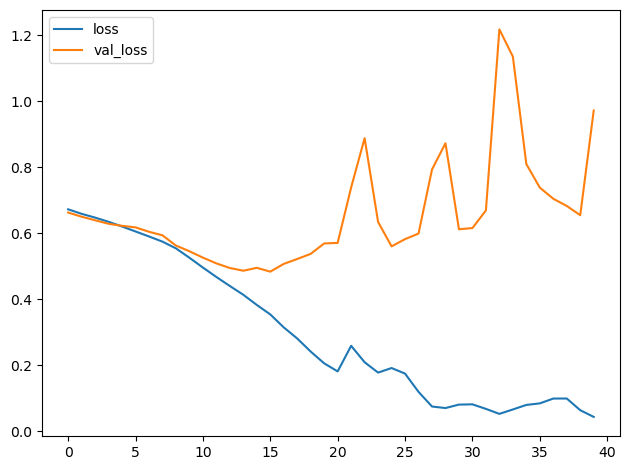

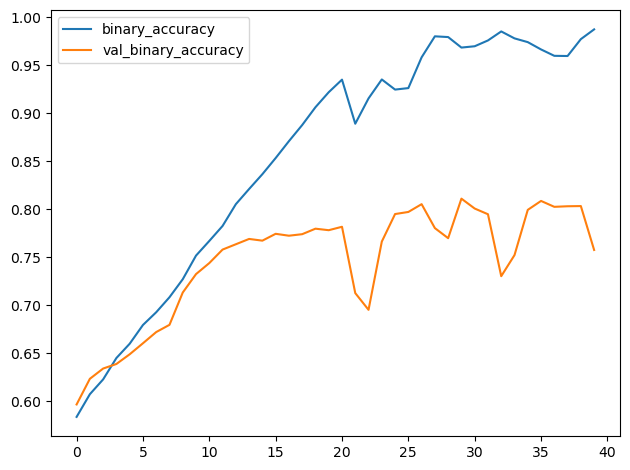

In [4]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

This model is much smaller than the VGG16 model from Lesson 1 -- only 3 convolutional layers versus the 16 of VGG16. It was nevertheless able to fit this dataset fairly well. We might still be able to improve this simple model by adding more convolutional layers, hoping to create features better adapted to the dataset. This is what we'll try in the exercises.

# Conclusion #

In this tutorial, you saw how to build a custom convnet composed of many **convolutional blocks** and capable of complex feature engineering. 

# Your Turn #

In the exercises, you'll create a convnet that performs as well on this problem as VGG16 does -- without pretraining! [**Try it now!**](https://www.kaggle.com/kernels/fork/11989565)

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/computer-vision/discussion) to chat with other learners.*